In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import numpy as np
import squarify

import matplotlib.ticker as ticker

In [2]:
borrow            = pd.read_csv('AAVE_V1/Borrow.csv')
borrow._timestamp = pd.to_datetime(borrow._timestamp)
borrow            = borrow.drop_duplicates()

deposit            = pd.read_csv('AAVE_V1/Deposit.csv')
deposit._timestamp = pd.to_datetime(deposit._timestamp)
deposit            = deposit.drop_duplicates()

liquidation            = pd.read_csv('AAVE_V1/LiquidationCall.csv')
liquidation._timestamp = pd.to_datetime(liquidation._timestamp)
liquidation            = liquidation.drop_duplicates()

redeem            = pd.read_csv('AAVE_V1/RedeemUnderlying.csv')
redeem._timestamp = pd.to_datetime(redeem._timestamp)
redeem            = redeem.drop_duplicates()

repay            = pd.read_csv('AAVE_V1/Repay.csv')
repay._timestamp = pd.to_datetime(repay._timestamp)
repay            = repay.drop_duplicates()

price = pd.read_csv('AAVE_V1/V1_price.csv')
price = price.drop_duplicates('blockNumber')
price = price.set_index('blockNumber')

In [3]:
repay_liqu = repay[(repay._user != repay._repayer)]
print('There were ', len(repay_liqu), ' repayments executed by 3rd parties.\n')
print('This equals ', round(len(repay_liqu)/len(repay)*100, 3), '%')

There were  1445  repayments executed by 3rd parties.

This equals  2.365 %


In [4]:
print(len(liquidation), len(repay))

4685 61093


In [5]:
from web3 import Web3
#from joblib import Parallel, delayed
#from datetime import datetime
#import time

endPoint = "wss://speedy-nodes-nyc.moralis.io/d61daff0632b8f2bb3fcc91e/eth/mainnet/archive/ws" # Better endPoint
# endPoint = 'wss://speedy-nodes-nyc.moralis.io/d61daff0632b8f2bb3fcc91e/eth/mainnet/ws'

w3 = Web3(Web3.WebsocketProvider(endPoint))

bN = []
bN += list(borrow.blockNumber)
bN += list(deposit.blockNumber)
bN += list(liquidation.blockNumber)
bN += list(repay.blockNumber)
bN += list(redeem.blockNumber)
bN = list(set(bN))

bN1 = int(np.min(bN))
bN2 = int(np.max(bN))

start = pd.to_datetime(w3.eth.get_block(bN1).timestamp, unit='s').strftime('%Y-%m-%d')
end   = pd.to_datetime(w3.eth.get_block(bN2).timestamp, unit='s').strftime('%Y-%m-%d')

print('We analyse the transaction data of AAVE v1 from block %s to %s.\nThis is equivalent to time from %s to %s.'
    %(bN1,bN2, start, end),'\n')

print('Total Number of transactions:\n', len(liquidation)+len(borrow)+len(deposit)+len(redeem)+len(repay))

We analyse the transaction data of AAVE v1 from block 9241323 to 13953589.
This is equivalent to time from 2020-01-08 to 2022-01-06. 

Total Number of transactions:
 455649


In [8]:
print('Number of borrowers:   ', len(borrow._user.value_counts()))
print('Number of liquidators: ', len(liquidation._liquidator.value_counts()))
print('Number of depositors:  ', len(deposit._user.value_counts()))
print('Number of lenders:     ', len(deposit._user.value_counts()) - len(borrow._user.value_counts()), '   (depositors minus borrowers)')

Number of borrowers:    10583
Number of liquidators:  482
Number of depositors:   36660
Number of lenders:      26077    (depositors minus borrowers)


In [9]:
'''
stable interest rate:   1
variable interest rate: 2
'''
interest = borrow._borrowRateMode.value_counts()
interest_share = interest[:]/interest[:].sum()
pd.concat([interest, interest_share], axis=1, keys=['Rate Mode', 'Percent'])

,Rate Mode,Percent
2,63654,0.771003
1,18906,0.228997


In [7]:
'''
popular coins for borrowing
'''
n = 5

# colormap for plots
cmap = plt.get_cmap('viridis')
col  = [cmap(i) for i in np.linspace(0, 1, n+1)]

# coins by NUMBER
loans_num   = borrow.reserveName.value_counts()
shares_num  = loans_num[:]/loans_num[:].sum()
loans_all   = pd.concat([loans_num,shares_num], axis=1, keys=['Total', 'Percent'])

# summarize small shares by 'other'
loans_summary = loans_num[:n].copy()
other_num     = pd.Series(loans_num[n:].sum(), index=['Other'])
loans_summary = pd.concat([loans_summary, other_num])
shares_other  = loans_summary[:]/loans_summary[:].sum()
loans_summary = pd.concat([loans_summary,shares_other], axis=1, keys=['Total', 'Percent'])

#coins by VALUE
loans_val = borrow.groupby(['reserveName'])['amountUSDT'].sum().sort_values(ascending=False)
shares_val  = loans_val[:]/loans_val[:].sum()
loans_all2   = pd.concat([loans_val,shares_val], axis=1, keys=['Total', 'Percent'])

# summarize small shares by 'other'
loans_summary2 = loans_val[:n].copy()
other_val = pd.Series(loans_val[n:].sum(), index=['Other'])
loans_summary2 = pd.concat([loans_summary2, other_val])
shares_other  = loans_summary2[:]/loans_summary2[:].sum()
loans_summary2 = pd.concat([loans_summary2,shares_other], axis=1, keys=['Total', 'Percent'])

print('Loans by Number and Value in USDT:')
print(loans_summary)
print(loans_summary2)

Loans by Number and Value in USDT:
       Total   Percent
USDC   20736  0.251163
USDT   16608  0.201163
DAI    11370  0.137718
TUSD   10642  0.128900
ETH     7538  0.091303
Other  15666  0.189753
              Total   Percent
USDC   1.702163e+09  0.233002
USDT   1.225668e+09  0.167776
ETH    1.090235e+09  0.149238
DAI    6.640373e+08  0.090897
TUSD   6.583949e+08  0.090125
Other  1.964866e+09  0.268962


In [136]:
plt.title('Popular Coins by Count')
squarify.plot(loans_summary.Total, label=loans_summary.index, color=col, alpha=0.75)
#plt.savefig('plots/popular_borrowings.png', transparent=True)
plt.close()

plt.title('Popular Coins by Value in USDT')
squarify.plot(loans_summary2.Total, label=loans_summary2.index, color=col, alpha=0.75)
#plt.savefig('plots/popular_borrowings_vol.png', transparent=True)
plt.close()

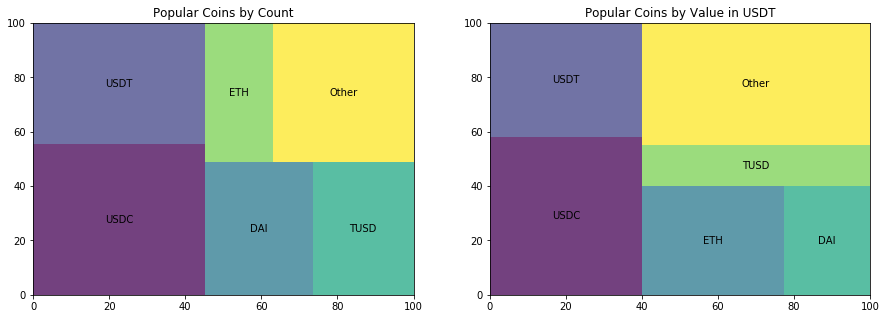

In [8]:
#plot both
fig = plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Popular Coins by Count')
squarify.plot(loans_summary.Total, label=loans_summary.index, color=col, alpha=0.75)

plt.subplot(1, 2, 2)
plt.title('Popular Coins by Value in USDT')
squarify.plot(loans_summary2.Total, label=loans_summary2.index, color=col, alpha=0.75)

plt.show()

In [130]:
loans_dep = pd.concat([loans_summary2,dep_summary2], keys=['Loans', 'Deposits'], axis=1, ignore_index = False)
loans_dep
#.Total.plot(kind = 'bar')

C:\Users\Ramona\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Loans                Deposits          
              Total   Percent         Total   Percent
DAI    6.640373e+08  0.090897  1.104772e+09  0.034880
ETH    1.090235e+09  0.149238  1.663284e+10  0.525141
LINK   6.316076e+08  0.086458  1.642350e+09  0.051853
Other  1.333259e+09  0.182504  3.034260e+09  0.095799
TUSD   6.583949e+08  0.090125           NaN       NaN
USDC   1.702163e+09  0.233002  4.521552e+09  0.142757
USDT   1.225668e+09  0.167776  2.315446e+09  0.073105
WBTC            NaN       NaN  2.421842e+09  0.076464

In [9]:
'''
frequently liquidated
'''
n = 6

# coins by NUMBER
liqu_num   = liquidation.collateralName.value_counts()
shares_num = liqu_num[:]/liqu_num[:].sum()
liqu_all   = pd.concat([liqu_num,shares_num], axis=1, keys=['Total', 'Percent'])

# summarize small shares by 'other'
liqu_summary = liqu_num[:n].copy()
other_num    = pd.Series(liqu_num[n:].sum(), index=['Other'])
liqu_summary = pd.concat([liqu_summary, other_num])
shares_other = liqu_summary[:]/liqu_summary[:].sum()
liqu_summary = pd.concat([liqu_summary,shares_other], axis=1, keys=['Total', 'Percent'])

#coins by VALUE
liqu_val   = liquidation.groupby(['collateralName'])['liquidatedCollateralAmountUSDT'].sum().sort_values(ascending=False)
shares_val = liqu_val[:]/liqu_val[:].sum()
liqu_all2  = pd.concat([liqu_val,shares_val], axis=1, keys=['Total', 'Percent'])

# summarize small shares by 'other'
liqu_summary2 = liqu_val[:n].copy()
other_val = pd.Series(liqu_val[n:].sum(), index=['Other'])
liqu_summary2 = pd.concat([liqu_summary2, other_val])
shares_other  = liqu_summary2[:]/liqu_summary2[:].sum()
liqu_summary2 = pd.concat([liqu_summary2,shares_other], axis=1, keys=['Total', 'Percent'])

print('Liquidations by Number and Value in USDT:')
print(liqu_summary)
print(liqu_summary2)

Liquidations by Number and Value in USDT:
       Total   Percent
ETH     1306  0.278762
LINK    1209  0.258058
USDC     512  0.109285
DAI      403  0.086019
LEND     284  0.060619
WBTC     253  0.054002
Other    718  0.153255
              Total   Percent
ETH    4.650938e+07  0.308031
USDC   4.025725e+07  0.266623
LINK   3.404073e+07  0.225451
WBTC   1.415339e+07  0.093738
YFI    1.050351e+07  0.069565
LEND   2.099973e+06  0.013908
Other  3.425048e+06  0.022684


In [48]:
plt.title('Liquidations by Count')
squarify.plot(liqu_summary.Total, label=liqu_summary.index, color=col, alpha=0.75)
plt.savefig('plots/freq_liqu.png', transparent=True)
plt.close()

plt.title('Liquidations by Value in USDT')
squarify.plot(liqu_summary2.Total, label=liqu_summary2.index, color=col, alpha=0.75)
plt.savefig('plots/freq_liqu_vol.png', transparent=True)
plt.close()

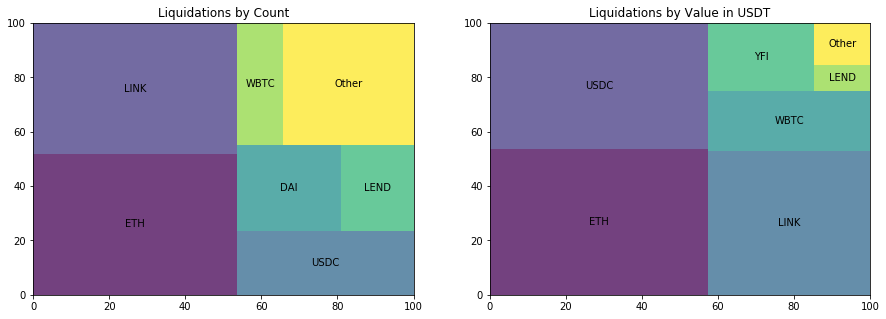

In [14]:
n = 6

# colormap for plots
cmap = plt.get_cmap('viridis')
col  = [cmap(i) for i in np.linspace(0, 1, n+1)]

#plot both
fig = plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Liquidations by Count')
squarify.plot(liqu_summary.Total, label=liqu_summary.index, color=col, alpha=0.75)

plt.subplot(1, 2, 2)
plt.title('Liquidations by Value in USDT')
squarify.plot(liqu_summary2.Total, label=liqu_summary2.index, color=col, alpha=0.75)

plt.show()

In [11]:
'''
Coins most common as deposits in general
'''
n = 6

# coins by NUMBER
dep_num   = deposit.reserveName.value_counts()
shares_num  = dep_num[:]/dep_num[:].sum()
dep_all   = pd.concat([dep_num,shares_num], axis=1, keys=['Total', 'Percent'])

# summarize small shares by 'other'
dep_summary = dep_num[:n].copy()
other_num     = pd.Series(dep_num[n:].sum(), index=['Other'])
dep_summary = pd.concat([dep_summary, other_num])
shares_other  = dep_summary[:]/dep_summary[:].sum()
dep_summary = pd.concat([dep_summary,shares_other], axis=1, keys=['Total', 'Percent'])

#coins by VALUE
dep_val = deposit.groupby(['reserveName'])['amountUSDT'].sum().sort_values(ascending=False)
shares_val  = dep_val[:]/dep_val[:].sum()
dep_all2   = pd.concat([dep_val,shares_val], axis=1, keys=['Total', 'Percent'])

# summarize small shares by 'other'
dep_summary2 = dep_val[:n].copy()
other_val    = pd.Series(dep_val[n:].sum(), index=['Other'])
dep_summary2 = pd.concat([dep_summary2, other_val])
shares_other = dep_summary2[:]/dep_summary2[:].sum()
dep_summary2 = pd.concat([dep_summary2,shares_other], axis=1, keys=['Total', 'Percent'])

print('Deposits by Number and Value in USDT:')
print(dep_summary)
print(dep_summary2)

Deposits by Number and Value in USDT:
       Total   Percent
ETH    37316  0.217872
LINK   25661  0.149823
DAI    21366  0.124747
USDT   14245  0.083170
USDC   13273  0.077495
SNX     8851  0.051677
Other  50563  0.295215
              Total   Percent
ETH    1.663284e+10  0.525141
USDC   4.521552e+09  0.142757
WBTC   2.421842e+09  0.076464
USDT   2.315446e+09  0.073105
LINK   1.642350e+09  0.051853
DAI    1.104772e+09  0.034880
Other  3.034260e+09  0.095799


In [46]:
plt.title('Deposits by Value in USDT')
squarify.plot(dep_summary2.Total, label=dep_summary2.index, color=col, alpha=0.75)
plt.savefig('plots/dep_vol.png', transparent=True)
plt.close()

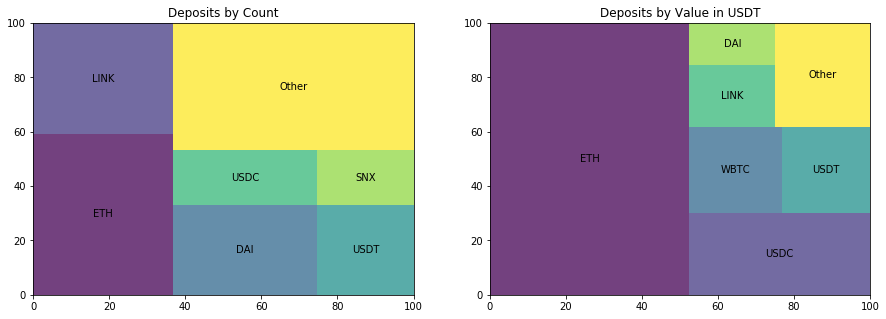

In [15]:
n = 6

# colormap for plots
cmap = plt.get_cmap('viridis')
col  = [cmap(i) for i in np.linspace(0, 1, n+1)]

#plot both
fig = plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Deposits by Count')
squarify.plot(dep_summary.Total, label=dep_summary.index, color=col, alpha=0.75)

plt.subplot(1, 2, 2)
plt.title('Deposits by Value in USDT')
squarify.plot(dep_summary2.Total, label=dep_summary2.index, color=col, alpha=0.75)

plt.show()

In [102]:
liquidation.head()

,Unnamed: 0,Unnamed: 0.1,reserveName,collateralName,purchaseAmountCleaned,liquidatedCollateralAmountCleaned,_timestamp,blockNumber,status,_user,_liquidator,liquidatedCollateralAmountUSDT,liquidatedCollateralAmountETH,purchaseAmountUSDT,purchaseAmountETH
0,0,0x9e55dfbd0cc1cea086788b72362df3f85b566f76ca75...,USDC,REN,7761.422843,23347.182055,2020-09-04 00:06:52,10791448,1.0,0x03f35Bf158c39dE0D3a9E59C60CD5Dfdd89012d6,0xb00ba6778cF84100da676101e011B3d229458270,8497.135912,22.449275,7724.669011,20.408432
1,1,0x7ebf47875043f0bdf2ab9d927df4d49cd3ccf2000770...,BAT,ETH,746.088000,0.233737,2021-12-16 14:36:30,13816747,1.0,0xc0a4352241F4eFBad1A919398Ad1F77Bd591c5de,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,952.627220,0.233737,907.264019,0.222607
2,2,0x6a74707a2d0d378dc59b3dcf1c7fd4b014bf7e04713b...,DAI,ETH,0.341260,0.001016,2020-09-14 11:45:01,10859900,1.0,0x28030a0c1ab5Da0FadaF886246C46Cf4e86F9345,0xf3e11d89b07e738F31dE12e8D8CFa0EAc7867A37,0.374754,0.001016,0.356909,0.000968
3,3,0x0239ea64d6db341454b365483822743f038c5e52e5eb...,ETH,DAI,0.136409,184.528007,2021-01-21 08:31:28,11697705,1.0,0x259Ae1412D4EB1b92ef9644fbcF24458be760B32,0xe069CB01D06bA617bCDf789bf2ff0D5E5ca20C71,186.196171,0.143230,177.329687,0.136409
4,4,0x6ba938c09a50992409ade58332a6ef04fd2b16ec43b0...,USDC,LEND,4497.547072,1507.118141,2021-05-22 04:47:05,12482056,1.0,0x01975a07D85f8Ec242e46241086889F2CfeD9390,0x5aF7F71C7747fb0ECEB2eEf115c3fA34dd4998D3,4975.566782,2.201340,4523.242529,2.001218


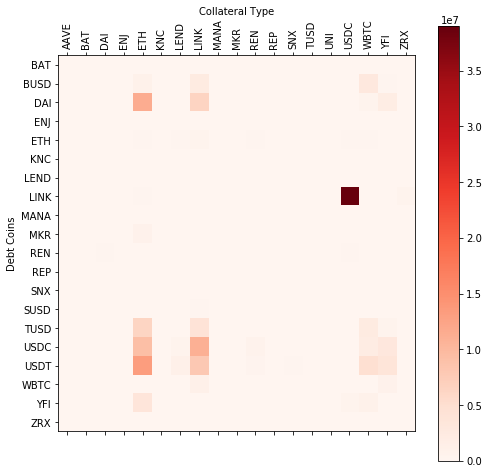

In [17]:
'''
plot liquidations by value in USDT
'''

PT1 = pd.pivot_table(liquidation,
               index='collateralName', columns= 'reserveName',
               values='liquidatedCollateralAmountUSDT',
               aggfunc='sum').fillna(0)

collateralNames = list(PT1.index)
reserveNames = list(PT1.columns)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#cax = ax.matshow(PT1.T, interpolation='nearest', cmap='seismic')
#cax = ax.matshow(PT1.T, interpolation='nearest', cmap='viridis')
cax = ax.matshow(PT1.T, interpolation='nearest', cmap='Reds')
fig.colorbar(cax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(['']+collateralNames, rotation=90)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_yticklabels(['']+reserveNames)

ax.xaxis.set_label_position('top') 
#ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Collateral Type')
ax.set_ylabel('Debt Coins')
#ax.set_title('Total Value in USDT')

plt.show()

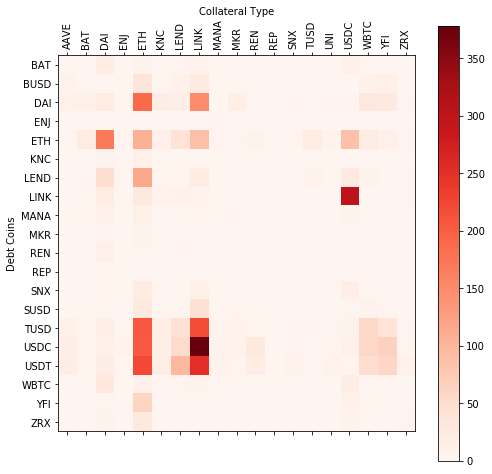

In [21]:
'''
plot liquidations by total number
'''

PT2 = pd.pivot_table(liquidation,
               index='collateralName', columns= 'reserveName',
               values='status',
               aggfunc='sum').fillna(0)

collateralNames = list(PT2.index)
reserveNames = list(PT2.columns)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#cax = ax.matshow(PT2.T, interpolation='nearest', cmap='seismic')
#cax = ax.matshow(PT2.T, interpolation='nearest', cmap='viridis')
cax = ax.matshow(PT2.T, interpolation='nearest', cmap='Reds')
fig.colorbar(cax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(['']+collateralNames, rotation=90)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_yticklabels(['']+reserveNames)

ax.xaxis.set_label_position('top') 
#ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Collateral Type')
ax.set_ylabel('Debt Coins')
#ax.set_title('Total Number of Liquidations')

plt.savefig('plots/freq_coin_combinations.png', transparent=True)

plt.show()

In [22]:
pd.options.mode.chained_assignment = None
eth_liqu = liquidation[(liquidation.collateralName == 'ETH')]
price_eth = price[['ETH', 'USDC', 'USDT']]
price_eth['ETH_USDT'] = price_eth.ETH/price_eth.USDT

eth_liqu = price_eth.merge(eth_liqu, on=['blockNumber'], how='outer')
#eth_liqu.head()

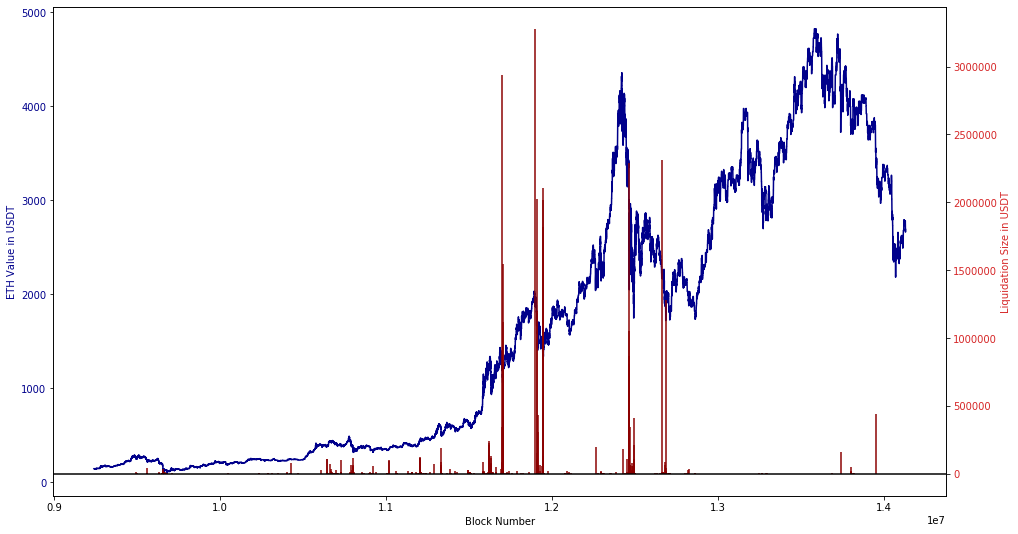

In [28]:
fig, ax1 = plt.subplots(figsize=(16,9))

color = 'darkblue'
ax1.set_xlabel('Block Number')
ax1.set_ylabel('ETH Value in USDT', color=color)
ax1.plot(eth_liqu.blockNumber, eth_liqu.ETH_USDT, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Liquidation Size in USDT', color=color)  
ax2.stem(eth_liqu.blockNumber, eth_liqu.liquidatedCollateralAmountUSDT, 'darkred', markerfmt = ' ', basefmt = ' ', use_line_collection=True)
ax2.axhline(y=0, color='black')
ax2.tick_params(axis='y', labelcolor=color)

#plt.title('')
#fig.tight_layout() 
#plt.savefig('.png', transparent=True)
plt.show()

In [24]:
endPoint = "wss://speedy-nodes-nyc.moralis.io/d61daff0632b8f2bb3fcc91e/eth/mainnet/archive/ws" # Better endPoint
# endPoint = 'wss://speedy-nodes-nyc.moralis.io/d61daff0632b8f2bb3fcc91e/eth/mainnet/ws'

w3 = Web3(Web3.WebsocketProvider(endPoint))

# Added block time
timeLabels = []
for item in ax1.get_xticklabels():
    bN = int(item.get_unitless_position()[0])
    try:
        block = w3.eth.get_block(bN)
        time = pd.to_datetime(block.timestamp, unit='s')
        timeLabels.append(time.strftime('%Y-%m-%d'))
    except:
        timeLabels.append(' ')

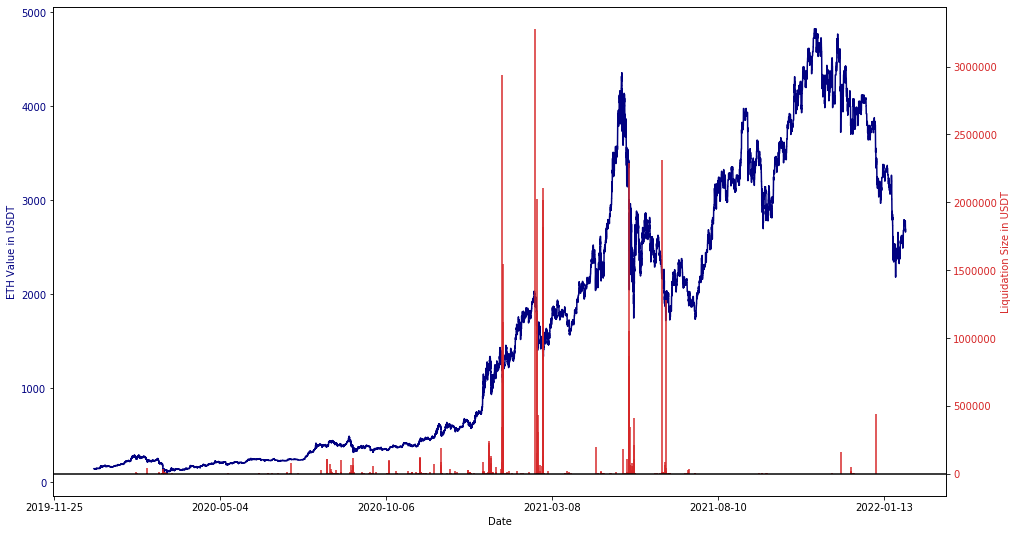

In [29]:
fig, ax1 = plt.subplots(figsize=(16,9))
#fig, ax1 = plt.subplots(figsize=(12,8))

color = 'navy'
ax1.set_xlabel('Date')
ax1.set_ylabel('ETH Value in USDT', color=color)
ax1.plot(eth_liqu.blockNumber, eth_liqu.ETH_USDT, color=color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Liquidation Size in USDT', color=color)  
ax2.stem(eth_liqu.blockNumber, eth_liqu.liquidatedCollateralAmountUSDT, 'tab:red', markerfmt = ' ', basefmt = ' ', use_line_collection=True)
ax2.axhline(y = 0, color = 'black')
ax2.tick_params(axis = 'y', labelcolor = color)

ax1.set_xticklabels(timeLabels)
#plt.title('')
#fig.tight_layout() 
#plt.savefig('plots/liqu_ETH_date_large.png', transparent=True)
#plt.savefig('plots/liqu_ETH_date_small.png', transparent=True)

plt.show()

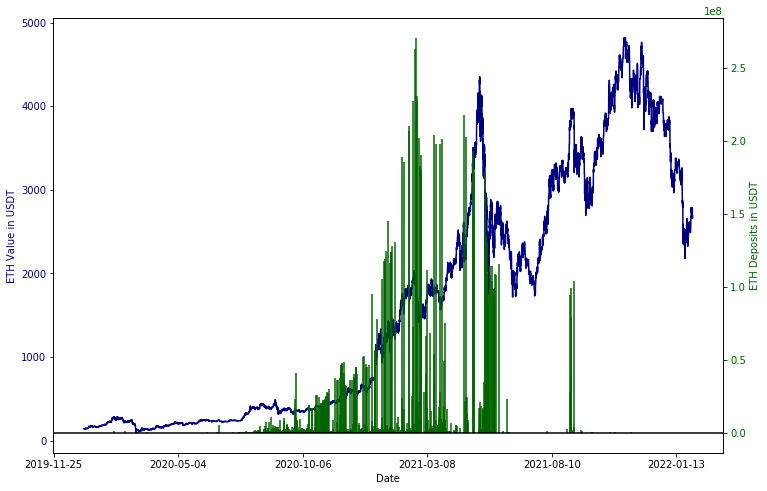

In [153]:
eth_dep = deposit[(deposit.reserveName == 'ETH')]
#price_eth = price[['ETH', 'USDC', 'USDT']]
#price_eth['ETH_USDT'] = price_eth.ETH/price_eth.USDT

eth_dep = price_eth.merge(eth_dep, on=['blockNumber'], how='outer')

#fig, ax1 = plt.subplots(figsize=(16,9))
fig, ax1 = plt.subplots(figsize=(12,8))

color = 'navy'
ax1.set_xlabel('Date')
ax1.set_ylabel('ETH Value in USDT', color=color)
ax1.plot(eth_dep.blockNumber, eth_dep.ETH_USDT, color=color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  

color = 'darkgreen'
ax2.set_ylabel('ETH Deposits in USDT', color=color)  
ax2.stem(eth_dep.blockNumber, eth_dep.amountUSDT, 'darkgreen', markerfmt = ' ', basefmt = ' ', use_line_collection=True)
ax2.axhline(y = 0, color = 'black')
ax2.tick_params(axis = 'y', labelcolor = color)

ax1.set_xticklabels(timeLabels)
#plt.title('')
#fig.tight_layout() 
#plt.savefig('plots/dep_ETH_date_large.png', transparent=True)
#plt.savefig('plots/dep_ETH_date_small.png', transparent=True)
plt.show()

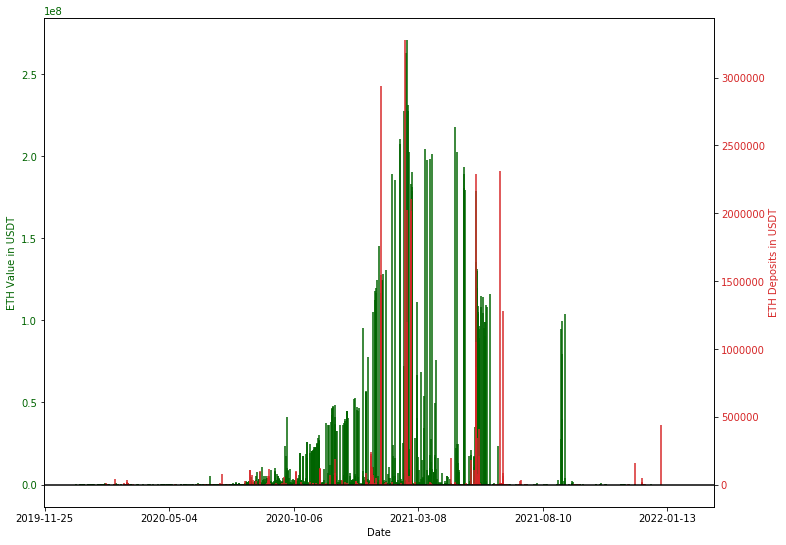

In [152]:
#fig, ax1 = plt.subplots(figsize=(16,9))
fig, ax1 = plt.subplots(figsize=(12,9))

color = 'darkgreen'
ax1.set_xlabel('Date')
ax1.set_ylabel('ETH Value in USDT', color=color)
ax1.stem(eth_dep.blockNumber, eth_dep.amountUSDT, 'darkgreen', markerfmt = ' ', basefmt = ' ', use_line_collection=True)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('ETH Deposits in USDT', color=color)  
ax2.stem(eth_liqu.blockNumber, eth_liqu.liquidatedCollateralAmountUSDT, 'tab:red', markerfmt = ' ', basefmt = ' ', use_line_collection=True)
ax2.axhline(y = 0, color = 'black')
ax2.tick_params(axis = 'y', labelcolor = color)

ax1.set_xticklabels(timeLabels)
#plt.title('')
#fig.tight_layout() 
#plt.savefig('dep_ETH_date_large.png', transparent=True)
#plt.savefig('dep_ETH_date_smal.png', transparent=True)
plt.show()

In [236]:
borrow.head()

,Unnamed: 0,reserveName,_borrowRateMode,amountCleaned,_timestamp,blockNumber,status,_user,amountUSDT,amountETH
0,0x8747f7ddb2fa68fc07569b15558d8cbb1e54c5adafb8...,USDT,1,532.854053,2020-07-26 12:48:57,10535185,1.0,0x7929Dc2FD612b33e800D2D9fb7e60af853516FcA,532.854053,1.745582
1,0x272ac09bad41c3e77b9ff4080d1114e8bd6e041b10c2...,USDT,2,10000.000000,2020-11-30 01:07:52,11356990,1.0,0x8F564c7272177663309F704065fFB59F403d96a1,10000.000000,17.010000
2,0xe1861b4585ad922a5f75a8acef9782572798ae72f2ff...,USDT,1,1000.000000,2020-11-30 17:41:49,11361558,1.0,0x3e17fac953DE2Cd729B0aCe7f6d4353387717e9e,1000.000000,1.665000
3,0x363fb49104d2760de391ab0217e9b11f579cf0e28b27...,USDT,2,5000.000000,2020-08-26 18:21:33,10737715,1.0,0x38148eCC2078dA7f65E6233DDA28eFaf4C51E96F,5000.000000,12.842550
4,0x658fc907d37c573eca7651ea6af5c1166fd850965849...,DAI,2,10810.803008,2020-07-01 21:09:48,10375893,1.0,0xb109B37202440206Af692dF4b17aEF885668844B,10949.844769,47.378993


In [265]:
import seaborn as sns

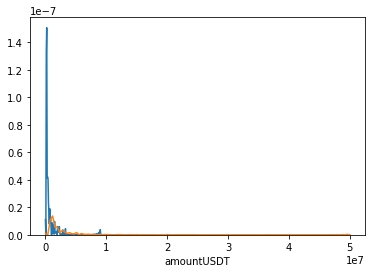

"\nsns.distplot(df_dict['LiquidationCall']['_purchaseAmount'], hist=True, kde=True, \n             bins=int(15), color = 'darkblue', \n             hist_kws={'edgecolor':'black'},\n             kde_kws={'linewidth': 4})\n"

In [238]:
sns.distplot(liquidation.liquidatedCollateralAmountUSDT, hist=False, kde=True)
#sns.distplot(borrow.amountUSDT, hist=False, kde=True)
plt.show()

Text(0.5, 1.0, 'Loan Size')

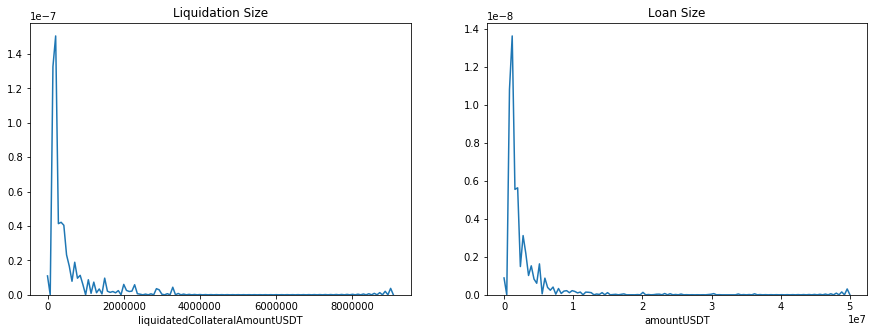

In [266]:
fig = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(liquidation.liquidatedCollateralAmountUSDT, hist=False, kde=True)
plt.title('Liquidation Size')
plt.subplot(1,2,2)
sns.distplot(borrow.amountUSDT, hist=False, kde=True)
plt.title('Loan Size')

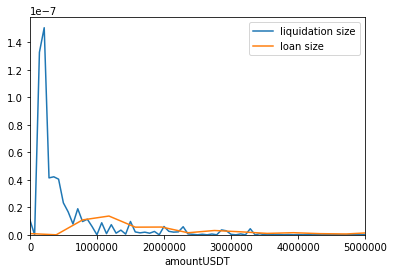

In [258]:
sns.distplot(liquidation.liquidatedCollateralAmountUSDT, hist=False, kde=True, label='liquidation size')
sns.distplot(borrow.amountUSDT, hist=False, kde=True, label='loan size')
plt.legend()
plt.xlim(0,0.5*1e7)
plt.show()

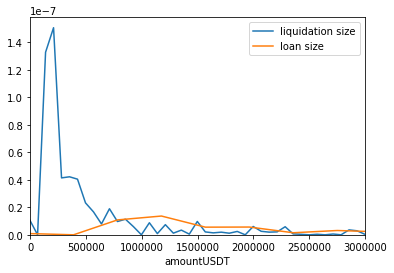

In [259]:
sns.distplot(liquidation.liquidatedCollateralAmountUSDT, hist=False, kde=True, label='liquidation size')
sns.distplot(borrow.amountUSDT, hist=False, kde=True, label='loan size')
plt.legend()
plt.xlim(0,0.3*1e7)
plt.show()